<div style="width: 100%; overflow: hidden; text-align:center;">
    <h1>INF-477 Redes Neuronales Artificiales</h1>
    <h2>Tarea 2 - Autoencoders, RBMs y ConvNets</h2><br/>
    <div style="width: 50%; float: left;">
        <h3>Gabriel Jara</h3>
        <h4>``gabriel.jara@usm.cl``</h4>
        <h4>13550188-3</h4>
    </div>
    <div style="margin-left: 300px;">
        <h3>Daniel San Martín</h3>
        <h4>``daniel.sanmartinr@sansano.usm.cl``</h4>
        <h4>682016101-5</h4>
    </div>
</div>

## 2 Aprendizaje Semi-Supervisado en NORB

Como hemos discutido en clases, uno de los problemas más relevantes a la hora de aplicar técnicas de aprendizaje automático a problemas es reales es el requisito de disponer de un gran número de datos etiquetados, es decir, ejemplos para los que se conoce la respuesta deseada del sistema. Un problema de aprendizaje para el que existen pocos datos etiquetados y muchos datos no etiquetados se denomina *semi-supervisado*. En esta sección, utilizaremos la idea de pre-entrenar una red en modo no supervisado para atacar problemas de aprendizaje semi-supervisado. Con este objetivo en mente, trabajaremos con un dataset denominado NORB, introducido en [9] y utilizado en [10], que corresponde a imágenes estéreo de juguetes clasificados en 6 categorías. Se tienen $291600$ ejemplos de entrenamiento y $58320$ ejemplos de pruebas.

<img width="50%" src="img/figure2.png">
<center>Fig. 2: Dataset NORB.</center>

Los datos asociados a esta actividad podrán ser obtenidos utilizando los siguientes comandos en la línea de comandos (sistemas UNIX)

1. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_1</code>
2. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_2</code>
3. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_3</code>
4. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_4</code>
5. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_5</code>
6. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_6</code>
7. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_7</code>
8. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_8</code>
9. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_9</code>
10. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_10</code>
11. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_11</code>
12. <code>wget http://octopus.inf.utfsm.cl/~ricky/data_batch_12</code>

Los primeros 10 batches corresponden a los datos de entrenamiento y los últimos 2 a los datos de pruebas. Los archivos corresponden a diccionarios serializados de python y pueden ser "extraídos" utilizando la siguiente función

In [1]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

Una vez extraído, cada diccionario contendrá 2 elementos importantes: data y labels. El primer elemento (data) es un matriz de $2048 \times n$ (numpy array). Cada columna de esa matriz corresponde a una imagen estéreo de un juguete: los primeros $1024$ valores vienen de una de las cámaras/vistas y los siguientes $1024$ de la otra. Por otro lado, el elemento (labels) del diccionario contiene una lista de $n$ valores enteros entre $0$ y $5$ que identifican las clases antes a las que pertenecen los juguetes.

(a) Construya una función que cargue todos los bloques de entrenamiento y pruebas del problema NORB generando como salida: (i) dos matrices $X_{tr}, Y_{tr}$, correspondientes a las imágenes y etiquetas de entrenamiento, (ii) dos matrices $X_t, Y_t$, correspondientes a las imágenes y etiquetas de pruebas, y finalmente (iii) dos matrices $X_v. Y_v$, correspondientes a imágenes y etiquetas que se usarán como conjunto de validación, es decir para tomar decisiones de diseño acerca del modelo. Este último conjunto debe ser extraído desde el conjunto de entrenamiento seleccionando $5832$ casos de cada batch.

In [2]:
import cPickle as pickle
import numpy as np
import os

# Cargar datos de entrenamiento y validacion
def load_NORB_train_val(PATH):
    xtr = []
    ytr = []
    xval = []
    yval = []
    
    # Para los primeros 10 batch
    for b in range(1,11):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array([datadict['labels']]).T
        Z = np.concatenate((X,Y),axis=1)
        np.random.shuffle(Z) # Al colocar Z = quedaba una variable vacia
        xtr.append(Z[5832:,0:-1])
        ytr.append(Z[5832:,-1])
        xval.append(Z[:5832,0:-1])
        yval.append(Z[:5832,-1])
    
    Xtr = np.concatenate(xtr)
    Ytr = np.concatenate(ytr)
    Xval = np.concatenate(xval)
    Yval = np.concatenate(yval)
    del xtr,ytr,xval,yval 
    return Xtr, Ytr, Xval, Yval

# Cargar datos de testing
def load_NORB_test(PATH):
    xte = []
    yte = []
    
    # Los dos ultimos batches
    for b in range(11, 13):
        f = os.path.join(PATH, 'data_batch_%d' % (b, ))
        datadict = unpickle(f)
        X = datadict['data'].T
        Y = np.array([datadict['labels']]).T
        xte.append(X)
        yte.append(Y)
    
    Xte = np.concatenate(xte)
    Yte = np.concatenate(yte)
    
    del xte, yte
    return Xte, Yte

(b) Construya una función que escale apropiadamente las imágenes antes de trabajar. Experimente escalando linealmente los datos de tal forma que cada pixel quede en el intervalo $[-1,1]$ con el máximo y mínimo valor observado en los extremos del intervalo. Evalúe más tarde la ventaja de centrar y escalar los datos para que cada atributo (pixel) tenga desviación estándar 1 y media nula.

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Cargar datos y normalizarlos en [-1,1]
def linear_normalize(a=-1, b=1):
    
    # Cargar datos
    Xtr, Ytr, Xval, Yval = load_NORB_train_val("data/")
    Xte, Yte = load_NORB_test("data/")
    
    # Para no sobrecargar la RAM
    Xtr = Xtr[:1000]
    Ytr = Ytr[:1000]
    Xval = Xval[:500]
    Yval = Yval[:500]
    Xte = Xte[:100]
    Yte = Yte[:100]
    
    # Normalizar datos entre [-1,1]
    scaler = MinMaxScaler(feature_range=(a, b)).fit(Xtr) 

    # Normalizacion del conjunto de entrenamiento
    Xtr_scaled = scaler.transform(Xtr)
    
    # Normalizacion del conjunto de testing
    Xte_scaled = scaler.transform(Xte)
    
    # Normalizacion del conjunto de validacion
    Xval_scaled = scaler.transform(Xval)
    
    del Xtr, Xte, Xval
    
    # Retornar los datesets
    return Xtr_scaled, Ytr, Xte_scaled, Yte, Xval_scaled, Yval

# Cargar y normalizar datos con media 0 y desviacion estandar 1
def normalize_data(centering=False, scaling=False):
    
    # Cargar datos
    Xtr, Ytr, Xval, Yval = load_NORB_train_val("data/")
    Xte, Yte = load_NORB_test("data/")
    
    # Se centra y escalan los datos si centering y scaling son True
    scaler = StandardScaler(with_mean=centering, with_std=scaling).fit(Xtr)
    
    # Normalización del conjunto de entrenamiento
    Xtr_scaled = scaler.transform(Xtr)
    
    # Normalización del conjunto de testing
    Xte_scaled = scaler.transform(Xte)
    
    # Normalización del conjunto de validacion
    Xval_scaled = scaler.transform(Xval)

    del Xtr, Xte, Xval
    
    # Retornar datasets
    return Xtr_scaled, Ytr, Xte_scaled, Yte, Xval_scaled, Yval

In [4]:
# Cargar datos normalizados
Xtr, Ytr, Xte, Yte, Xval, Yval = linear_normalize()

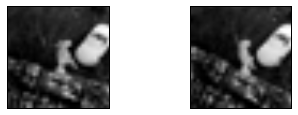

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# Ejemplo de imagen de training normalizada
ax = plt.subplot(2, 2, 1)
plt.imshow(Xtr[0, :1024].reshape(32,32))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax = plt.subplot(2, 2, 2)
plt.imshow(Xtr[0, 1024:].reshape(32,32))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.gray()

Se construyen las funciones correspondientes con la normalización entre $[-1, 1]$ y con distribución normal $\mu=0$, $\sigma=1$. Además se muestra una imagen de entrenamiento para ver la transformación.

(c) Su objetivo será ahora evaluar el desempeño de una red FF en un escenario semi-supervisado. Para ello simulará un situación en la que se tienen $n_s$ ejemplos de entrenamiento para los cuales se conoce
la etiqueta correcta y $n_{ns} = n_{tr} - n_s$ ejemplos para los cuales no se tiene esta información ($n_{tr}$ es el número total de ejemplos de entrenamiento). Para empezar, deberá entrenar una red FF con salida softmax para el problema NORB. Considere la inclusión de dos capas escondidas (de 4000 y 2000 unidades) y funciones de activación *relu*. Como parámetros de referencia considere: BP con tasa de aprendizaje constante, función de pérdida *cross-entropy binaria*, y mini batches de tamaño $10$. Puede utilizar el conjunto de validación para mejorar el entrenamiento. Construya un gráfico que muestre cómo evoluciona el error de pruebas como función de $\theta_s = n_s/n_{tr}$. Experimente con $\theta_s = 0.1, 0.2, ..., 1$.

In [6]:
# Librerias utilizadas
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.neural_network import BernoulliRBM # Para RBM
from numpy.random import binomial # Para mascara de dAE

# Graficos
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.


In [7]:
# Variables y funciones de uso comun

# Funcion para graficar resultados
def plot_error(theta, scores):
    plt.figure(figsize=(10,6))
    plt.plot(theta, 1 - scores)
    plt.title("Error vs " + r"$\theta_s$", fontsize=16)
    plt.grid(True)
    plt.ylabel("Error")
    plt.xlabel(r"$\theta$", fontsize=16)
    plt.show()

# \theta_s = {0.1, ..., 1}
theta = np.arange(0.1, 1.1, 0.1)
ntr = len(Xtr)

# Valores de n_s
ns = (theta*ntr).astype(int)
nt = len(theta)

In [8]:
# Red FF escenario semi-supervisado
def FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns, activation_):
    
    # Parametros
    loss_ = 'binary_crossentropy'
    optimizer_ = SGD(lr=0.01)
    n_hidden_layer1 = 4000
    n_hidden_layer2 = 2000
    nb_epoch_ = 1
    batch_size_ = 10
    
    # Numero de clases
    n_classes = 6

    # Tamaño 
    ntr = len(Xtr)
    nns = ntr - ns
    
    # Categorizar etiquetas
    Y_train = np_utils.to_categorical(Ytr, n_classes)
    Y_val = np_utils.to_categorical(Yval, n_classes)
    Y_test = np_utils.to_categorical(Yte, n_classes)
    
    # Conjunto de entrenamiento desconocido
    Y_train[ns:]  = -1
    
    ## Red FF
    model = Sequential()
        
    # Input layer - Hidden layer (4000 neuronas)
    model.add(Dense(n_hidden_layer1, input_dim=Xtr.shape[1], init='uniform')) 
    model.add(Activation(activation_))

    # Hidden layer (2000 neuronas)
    model.add(Dense(n_hidden_layer2, init='uniform'))
    model.add(Activation(activation_))

    # Output layer
    model.add(Dense(n_classes, init='uniform'))
    model.add(Activation('softmax'))

    # Compilar modelo
    model.compile(loss=loss_, optimizer=optimizer_, metrics=['accuracy'])
    
    # Ajuste de modelo
    model.fit(Xtr, Y_train, nb_epoch=nb_epoch_, batch_size=batch_size_, verbose=0, validation_data=(Xval, Y_val))
    
    # Evaluacion del modelo con datos de testing
    score = model.evaluate(Xte, Y_test)
    
    return score

In [9]:
# Guardar los scores del modelo FF
scores_ff = []

for i in range(nt):
    scores_ff.append(FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "relu"))

100/100 [==============================] - 0s     


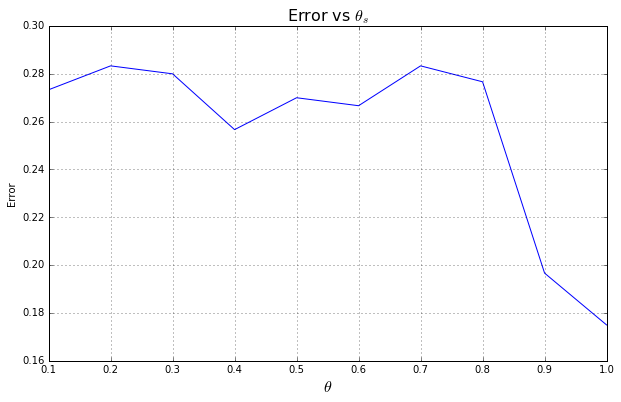

In [10]:
# Grafico de error vs theta
scores_ff = np.array(scores_ff)
plot_error(theta, scores_ff[:,1])

Notamos que para una mayor cantidad de datos etiquetados conocidos, la red presenta valores de error menores. Algo que podría ser evidente si pensamos que la red se entrena con un mayor volumen de datos.

(d) Su objetivo será ahora construir un gráfico similar al anterior que muestre cómo evoluciona el error de pruebas como función de $\theta_s = n_s/n_{tr}$ cuando la red se pre-entrena utilizando los datos no supervisados. ¿Mejora el resultado con respecto a la red entrenada utilizando sólo los casos para los que se conoce la etiqueta? Experimente pre-entrenando con distintas estrategias (por ejemplo AE's versus dAE's ó AE's versus RBM's).

In [11]:
# Red FF pre-entrenada con AE
def AE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns, activation_):
    
    # Parametros
    n_hidden_layer1 = 4000
    activation_layer1 = activation_
    decoder_activation_1 = activation_
    n_hidden_layer2 = 2000
    activation_layer2 = activation_
    decoder_activation_2 = activation_
    loss_ = 'binary_crossentropy'
    optimizer_ = SGD(lr=0.01)
    nb_epoch_ = 1
    batch_size_ = 10
    
    # Numero de clases
    n_classes = 6

    # Tamaño 
    ntr = len(Xtr)
    nns = ntr - ns
    
    # Categorizar etiquetas
    Y_train = np_utils.to_categorical(Ytr, n_classes)
    Y_val = np_utils.to_categorical(Yval, n_classes)
    Y_test = np_utils.to_categorical(Yte, n_classes)
    
    # Conjunto de entrenamiento desconocido
    Y_train[ns:]  = -1

    ###AUTOENCODER 1
    # Input layer del autoencoder 1
    input1 = Input(shape=(Xtr.shape[1],)) 
    
    # Capa codificadora
    encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input1)
    
    # Capa decodificadora
    decoded1 = Dense(Xtr.shape[1], activation=decoder_activation_1)(encoded1)
    
    # Autoencoder 1
    autoencoder1 = Model(input=input1, output=decoded1)
    
    # Codificador 1
    encoder1 = Model(input=input1, output=encoded1)
    
    # Compilar autoencoder
    autoencoder1.compile(optimizer=optimizer_, loss=loss_)
    
    # Ajuste autoencoder 1
    autoencoder1.fit(Xtr, Xtr, nb_epoch=nb_epoch_, batch_size=batch_size_, shuffle=True, 
                     verbose=0, validation_data=(Xval, Xval))
    encoded_input1 = Input(shape=(n_hidden_layer1,))

    ###AUTOENCODER 2
    
    #FORWARD PASS DATA THROUGH FIRST ENCODER
    x_train_encoded1 = encoder1.predict(Xtr) 
    x_val_encoded1 = encoder1.predict(Xval)
    x_test_encoded1 = encoder1.predict(Xte)
    
    # Input autoencoder 2
    input2 = Input(shape=(n_hidden_layer1,))
    
    # Capa codificadora
    encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input2)
    
    # Capa decodificadora
    decoded2 = Dense(n_hidden_layer1, activation=decoder_activation_2)(encoded2)
    
    # Autoencoder 2
    autoencoder2 = Model(input=input2, output=decoded2)
    
    # Encoder 2
    encoder2 = Model(input=input2, output=encoded2)
    
    # Compilar autoencoder
    autoencoder2.compile(optimizer=optimizer_, loss=loss_)
    
    # Ajustar autoencoder
    autoencoder2.fit(x_train_encoded1, x_train_encoded1, nb_epoch=nb_epoch_, batch_size=batch_size_, shuffle=True, 
                     verbose=0, validation_data=(x_val_encoded1, x_val_encoded1))
    encoded_input2 = Input(shape=(n_hidden_layer2,))

    #FINE TUNNING (FF)
    model = Sequential()
    
    # Input - Hidden layer (4000 neuronas)
    model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(Xtr.shape[1],)))
    model.layers[-1].set_weights(autoencoder1.layers[1].get_weights()) # se copian los pesos del autoencoder 1
    
    # Hidden layer (2000 neuronas)
    model.add(Dense(n_hidden_layer2, activation=activation_layer2))
    model.layers[-1].set_weights(autoencoder2.layers[1].get_weights()) # se copian los pesos del autoencoder 2
    
    # Output layer (6 neuronas)
    model.add(Dense(n_classes, activation='softmax'))
    
    # Compilar modelo
    model.compile(optimizer=optimizer_, loss=loss_, metrics=['accuracy'])
    
    # Entrenar modelo
    model.fit(Xtr, Y_train, nb_epoch=nb_epoch_, batch_size=batch_size_, shuffle=True, verbose=0, validation_data=(Xval, Y_val))
    
    # Evaluar modelo con data de testing
    score = model.evaluate(Xte, Y_test)
    
    return score

In [12]:
# Guardar los scores del modelo
nt = len(theta)
scores_ae = []

for i in range(nt):
    scores_ae.append(AE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, int(ns[i]), "relu"))

100/100 [==============================] - 0s     


Pre-entrenamiento con AE:


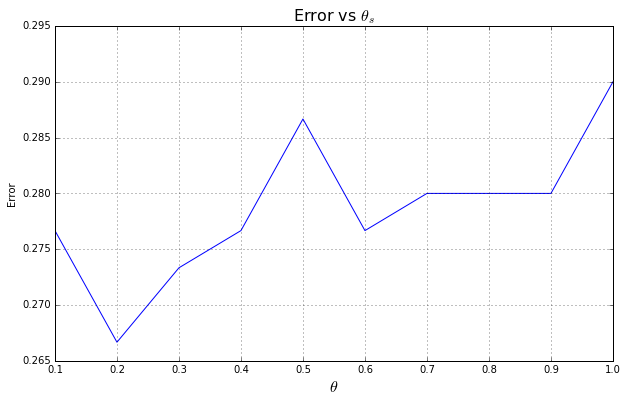

In [13]:
# Grafico de error vs theta (pre-entrenamiento con autoencoder)
print "Pre-entrenamiento con AE:"
scores_ae = np.array(scores_ae)
plot_error(theta, scores_ae[:,1])

Para el caso de pre-entrenamiento con *Autoencoder* vemos que que el error se oscila alrededor del 28%. Según la teoría se supone que al pre-entrenar una red es posible iniciar esta sobre un espacio de solución mejor que si esta no se pre-entrena.

In [14]:
# Red FF pre-entrenada con denoising AE
def dAE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns, activation_):
    
    # Parametros
    n_hidden_layer1 = 4000
    activation_layer1 = activation_
    decoder_activation_1 = activation_
    n_hidden_layer2 = 2000
    activation_layer2 = activation_
    decoder_activation_2 = activation_
    loss_ = 'binary_crossentropy'
    optimizer_ = SGD(lr=0.01)
    nb_epoch_ = 1
    batch_size_ = 10
    
    # Mascara de ruido
    noise_level = 0.6
    noise_mask = binomial(n=1, p=noise_level, size=Xtr.shape)
    noisy_x_train = Xtr*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=Xval.shape)
    noisy_x_val = Xval*noise_mask
    noise_mask = binomial(n=1,p=noise_level,size=Xte.shape)
    noisy_x_test = Xte*noise_mask
    
    # Numero de clases
    n_classes = 6

    # Tamaño 
    ntr = len(Xtr)
    nns = ntr - ns
    
    # Categorizar etiquetas
    Y_train = np_utils.to_categorical(Ytr, n_classes)
    Y_val = np_utils.to_categorical(Yval, n_classes)
    Y_test = np_utils.to_categorical(Yte, n_classes)
    
    # Conjunto de entrenamiento desconocido
    Y_train[ns:]  = -1

    # Model 
    # Input layer
    input_ = Input(shape=(Xtr.shape[1],))
    
    # Capa codificadora 1 (4000 neruonas)
    encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_)
    
    # Capa codificadora 2 (2000 neuronas)
    encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(encoded1)
    
    # Salida codificacion 
    encoded3 = Dense(Xtr.shape[1], activation=activation_layer2)(encoded2)
    
    # Capa decodificadora 2 (2000 neuronas)
    decoded3 = Dense(n_hidden_layer2, activation=activation_layer2)(encoded3)
    
    # Capa decodificadora 1 (4000 neuronas)
    decoded2 = Dense(n_hidden_layer1, activation=activation_layer1)(encoded2)
    
    # Salida decodificadora
    decoded1 = Dense(Xtr.shape[1], activation=activation_layer1)(decoded2)
    
    # Autoencoder
    autoencoder = Model(input=input_, output=decoded1)
    encoder = Model(input=input_, output=encoded2)
    
    # Compilar modelo
    autoencoder.compile(optimizer=optimizer_, loss='binary_crossentropy')
    
    # Ajuste del modelo con data ruidosa
    autoencoder.fit(noisy_x_train, Xtr, nb_epoch=nb_epoch_, batch_size=batch_size_, verbose=0, 
                    shuffle=True, validation_data=(noisy_x_val, Xval))
    
    #FINE TUNNING (FF)
    model = Sequential()
    
    # Input layer - Hidden layer (4000 neuronas)
    model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(Xtr.shape[1],)))
    model.layers[-1].set_weights(autoencoder.layers[1].get_weights()) # Se copian los pesos de la capa 1 del autoencoder
    
    # Hidden layer (2000 neuronas)
    model.add(Dense(n_hidden_layer2, activation=activation_layer2))
    model.layers[-1].set_weights(autoencoder.layers[2].get_weights())
    
    # Ouput layer
    model.add(Dense(n_classes, activation='softmax'))
    
    # Compilar modelo
    model.compile(optimizer=optimizer_, loss=loss_, metrics=['accuracy'])
    
    # Entrenar modelo
    model.fit(Xtr, Y_train, nb_epoch=nb_epoch_, batch_size=batch_size_, shuffle=True, verbose=0, 
              validation_data=(Xval, Y_val))
    
    # Evaluar modelo
    score = model.evaluate(Xte, Y_test)
    
    return score

In [15]:
# Guardar los scores del modelo dAE
nt = len(theta)
scores_dae = []

for i in range(nt):
    scores_dae.append(dAE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, int(ns[i]), "relu"))

100/100 [==============================] - 0s     


Pre-entrenamiento con dAE:


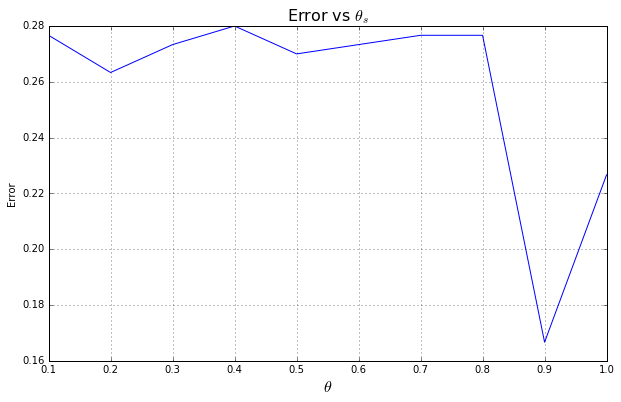

In [16]:
# Grafico de error vs theta (pre-entrenamiento con autoencoder)
print "Pre-entrenamiento con dAE:"
scores_dae = np.array(scores_dae)
plot_error(theta, scores_dae[:,1])

Para este caso vemos como para $\theta_s=0.8$ el error decae rápidamente.

In [17]:
# Red FF pre-entrenada con RBM's
def RBM_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns, activation_):
    
    # Parametros
    lr_ = 0.01
    optimizer_ = SGD(lr=0.01)
    loss_ = 'binary_crossentropy'
    nb_epoch_ = 1
    batch_size_ = 10
    n_hidden_layer1 = 4000
    activation_layer1 = activation_
    n_hidden_layer2 = 2000
    activation_layer2 = activation_
    
    # RBM's
    rbm1 = BernoulliRBM(n_components=n_hidden_layer1, batch_size=batch_size_, learning_rate=lr_, verbose=0, n_iter=nb_epoch_)
    rbm1.fit(Xtr) ##Train using persistent Gibbs chains
    encoded_train1 = rbm1.transform(Xtr)
    encoded_val1 = rbm1.transform(Xval)
    encoded_test1 = rbm1.transform(Xte)

    rbm2 = BernoulliRBM(n_components=n_hidden_layer2, batch_size=batch_size_, learning_rate=lr_, verbose=0, n_iter=nb_epoch_)
    rbm2.fit(encoded_train1)
    encoded_train2 = rbm2.transform(encoded_train1)
    encoded_val2 = rbm2.transform(encoded_val1)
    encoded_test2 = rbm2.transform(encoded_test1)

    weights1 = np.transpose(rbm1.components_) # Pesos capa 1
    bias1 = rbm1.intercept_hidden_
    w1 = [weights1 , bias1]

    weights2 = np.transpose(rbm2.components_) # Pesos cap a2
    bias2 = rbm2.intercept_hidden_
    w2 = [weights2 , bias2]
    
    # Numero de clases
    n_classes = 6

    # Tamaño 
    ntr = len(Xtr)
    nns = ntr - ns
    
    # Categorizar etiquetas
    Y_train = np_utils.to_categorical(Ytr, n_classes)
    Y_val = np_utils.to_categorical(Yval, n_classes)
    Y_test = np_utils.to_categorical(Yte, n_classes)
    
    # Conjunto de entrenamiento desconocido
    Y_train[ns:]  = -1

    #FINE TUNNING (FF)
    model = Sequential()
    
    # Input layer - Hidden layer (4000 neuronas)
    model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(Xtr.shape[1],)))
    model.layers[-1].set_weights(w1) # Se copian pesos de RBM 1
    
    # Hidden layer (2000 neuronas)
    model.add(Dense(n_hidden_layer2, activation=activation_layer2))
    model.layers[-1].set_weights(w2) # Se copian pesos de RBM 2
    
    # Output layer
    model.add(Dense(n_classes, activation='softmax'))
    
    # Compilar modelo
    model.compile(optimizer=optimizer_, loss=loss_, metrics=['accuracy'])
    
    # Ajustar modelo
    model.fit(Xtr, Y_train, nb_epoch=nb_epoch_, batch_size=batch_size_, shuffle=True, validation_data=(Xval, Y_val), verbose=0)
    
    # Evaluar modelo
    score = model.evaluate(Xte, Y_test)
    
    return score

In [18]:
# Guardar los scores del modelo RBM
nt = len(theta)
scores_rbm = []

for i in range(nt):
    scores_rbm.append(RBM_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, int(ns[i]), "relu"))

100/100 [==============================] - 0s     


Pre-entrenamiento con RBM:


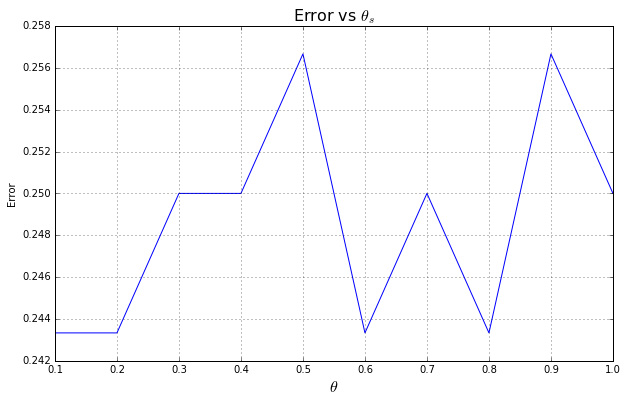

In [19]:
# Grafico de error vs theta (pre-entrenamiento con autoencoder)
print "Pre-entrenamiento con RBM:"
scores_rbm = np.array(scores_rbm)
plot_error(theta, scores_rbm[:,1])

Con RBM's vemos como el error oscila considerablemente entre 24-25%. Se logra apreciar igual para valores de $\theta_s$ entre $0.1-0.2$ se alcanzar los menores valores.

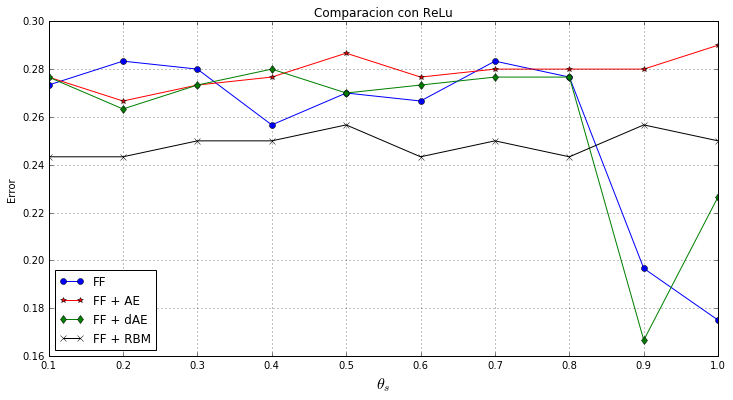

In [20]:
# Comparacion todos los modelos
plt.figure(figsize=(12, 6))
plt.plot(theta, 1 - scores_ff[:,1], 'b-o', label="FF")
plt.plot(theta, 1 - scores_ae[:,1], 'r-*', label="FF + AE")
plt.plot(theta, 1 - scores_dae[:,1], 'g-d', label="FF + dAE")
plt.plot(theta, 1 - scores_rbm[:,1], 'k-x', label="FF + RBM")
plt.title("Comparacion con ReLu")
plt.grid(True)
plt.legend(loc='bottom left')
plt.xlabel(r"$\theta_s$", fontsize=16)
plt.ylabel("Error")
plt.show()

Comparando todos los modelos juntos para funciones de activación ReLu, los errores oscilan entre el 24-28% y para el caso del denoising este obtine mejores resultados para valores etiquetados de un 90%.

(e) Repita el experimento anterior cambiando las funciones de activación a *sigmoidales* y *tanh*.

In [21]:
ff_sigmoid = []
ff_tanh = []

for i in range(nt):
    ff_sigmoid.append(FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "sigmoid"))
    ff_tanh.append(FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "tanh"))

100/100 [==============================] - 0s     


FF con sigmoidal


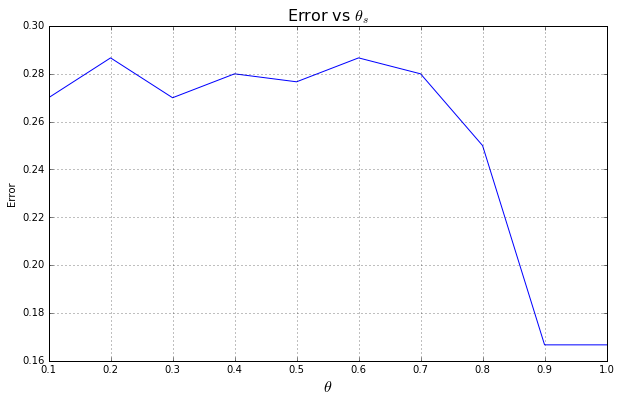

In [22]:
print "FF con sigmoidal"
ff_sigmoid = np.array(ff_sigmoid)
plot_error(theta, ff_sigmoid[:,1])

FF con tanh


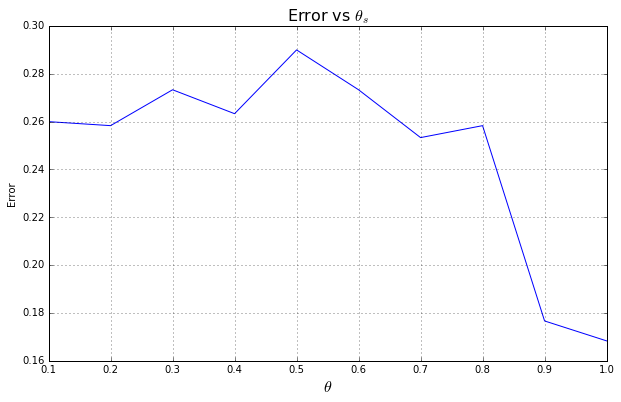

In [23]:
print "FF con tanh"
ff_tanh = np.array(ff_tanh)
plot_error(theta, ff_tanh[:,1])

In [24]:
ae_sigmoid = []
ae_tanh = []

for i in range(nt):
    ae_sigmoid.append(AE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "sigmoid"))
    ae_tanh.append(AE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "tanh"))

100/100 [==============================] - 0s     


FF + AE con sigmoid


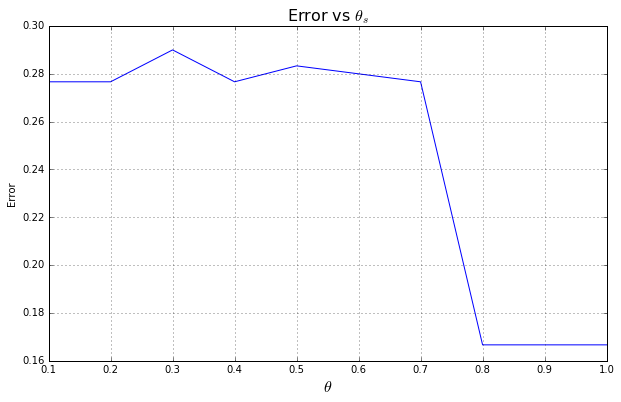

In [25]:
print "FF + AE con sigmoid"
ae_sigmoid = np.array(ae_sigmoid)
plot_error(theta, ae_sigmoid[:,1])

FF + AE con tanh


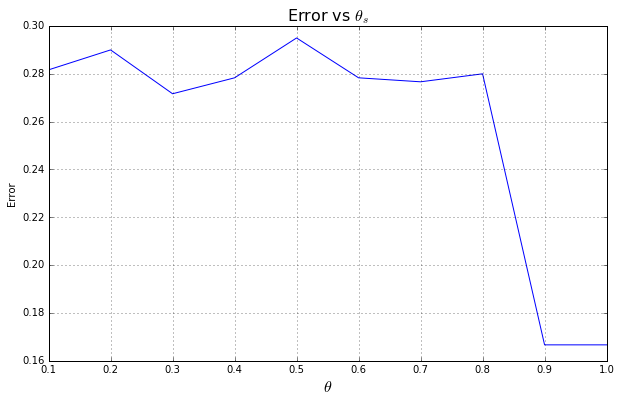

In [26]:
print "FF + AE con tanh"
ae_tanh = np.array(ae_tanh)
plot_error(theta, ae_tanh[:,1])

In [27]:
dae_sigmoid = []
dae_tanh = []

for i in range(nt):
    dae_sigmoid.append(dAE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "sigmoid"))
    dae_tanh.append(dAE_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "tanh"))

100/100 [==============================] - 0s     


FF + dAE con sigmoid


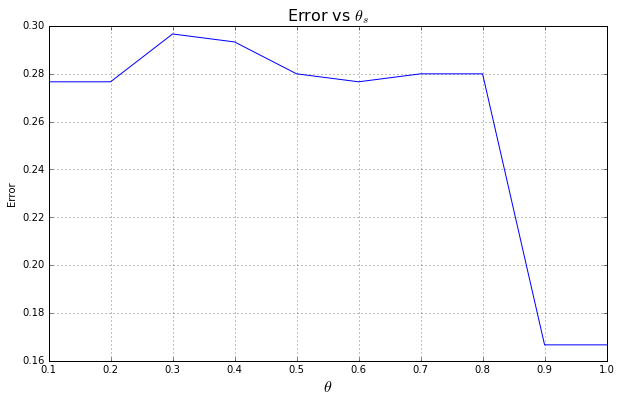

In [28]:
print "FF + dAE con sigmoid"
dae_sigmoid = np.array(dae_sigmoid)
plot_error(theta, dae_sigmoid[:,1])

FF + dAE con tanh


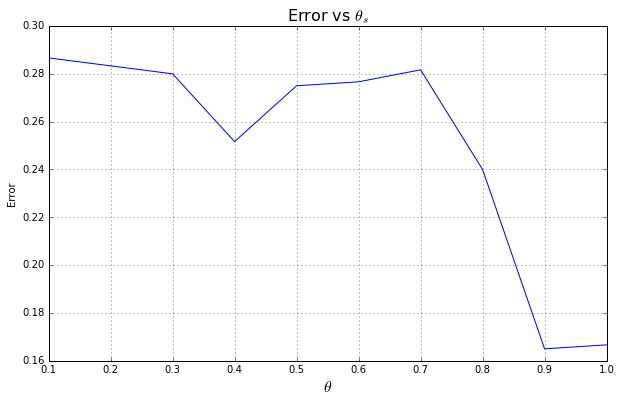

In [29]:
print "FF + dAE con tanh"
dae_tanh = np.array(dae_tanh)
plot_error(theta, dae_tanh[:,1])

In [30]:
rbm_sigmoid = []
rbm_tanh = []

for i in range(nt):
    rbm_sigmoid.append(RBM_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "sigmoid"))
    rbm_tanh.append(RBM_FF(Xtr, Ytr, Xval, Yval, Xte, Yte, ns[i], "tanh"))

100/100 [==============================] - 0s     


FF + dAE con sigmoide


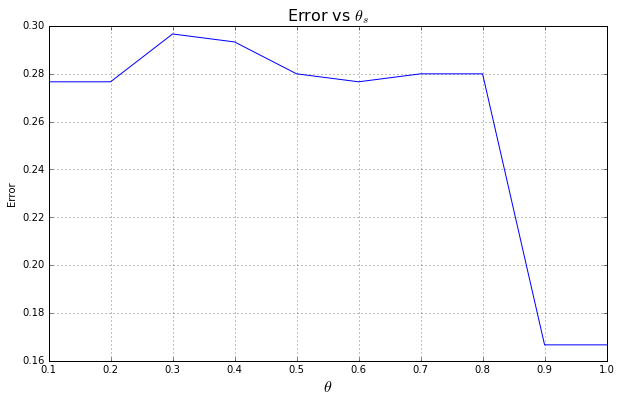

In [31]:
print "FF + dAE con sigmoide"
rbm_sigmoid = np.array(rbm_sigmoid)
plot_error(theta, dae_sigmoid[:,1])

FF + dAE con tanh


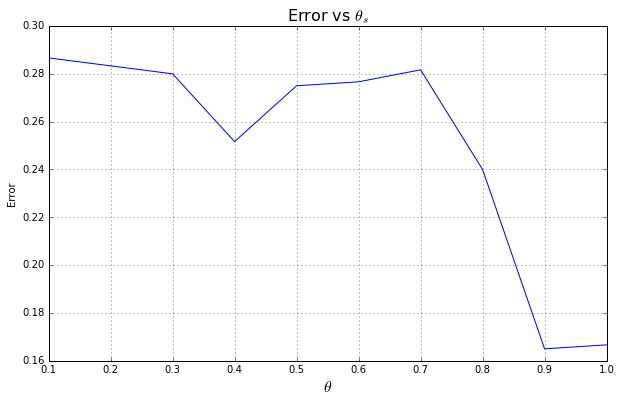

In [32]:
print "FF + dAE con tanh"
rbm_tanh = np.array(dae_tanh)
plot_error(theta, rbm_tanh[:,1])

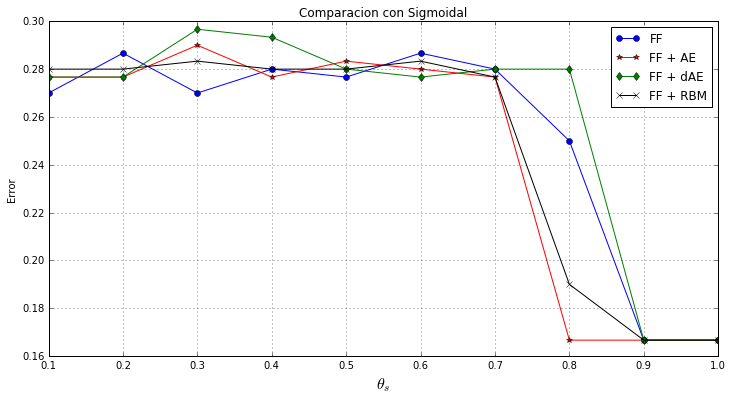

In [33]:
# Comparacion todos los modelos
plt.figure(figsize=(12, 6))
plt.plot(theta, 1 - ff_sigmoid[:,1], 'b-o', label="FF")
plt.plot(theta, 1 - ae_sigmoid[:,1], 'r-*', label="FF + AE")
plt.plot(theta, 1 - dae_sigmoid[:,1], 'g-d', label="FF + dAE")
plt.plot(theta, 1 - rbm_sigmoid[:,1], 'k-x', label="FF + RBM")
plt.title("Comparacion con Sigmoidal")
plt.grid(True)
plt.legend(loc='bottom left')
plt.xlabel(r"$\theta_s$", fontsize=16)
plt.ylabel("Error")
plt.show()

Para funcion de activación Sigmoidal notamos como todos los modelos con el 80% de datos etiquetados alcanzan un error bajo comparable a lo que alcanza una red pre-entrenada con ReLu con el 90% de datos etiquetados.

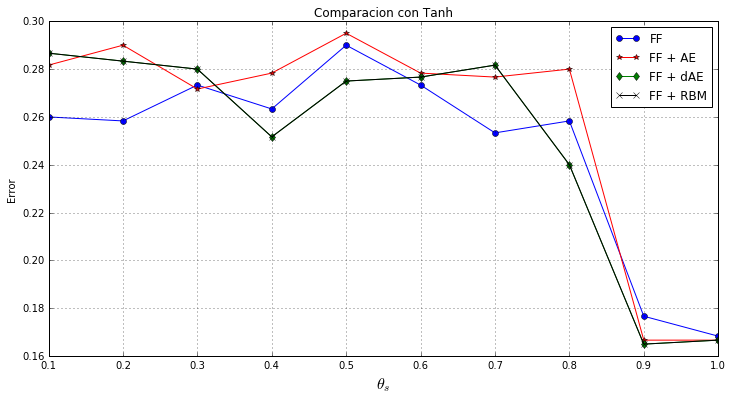

In [34]:
# Comparacion todos los modelos Tanh
plt.figure(figsize=(12, 6))
plt.plot(theta, 1 - ff_tanh[:,1], 'b-o', label="FF")
plt.plot(theta, 1 - ae_tanh[:,1], 'r-*', label="FF + AE")
plt.plot(theta, 1 - dae_tanh[:,1], 'g-d', label="FF + dAE")
plt.plot(theta, 1 - rbm_tanh[:,1], 'k-x', label="FF + RBM")
plt.title("Comparacion con Tanh")
plt.grid(True)
plt.legend(loc='bottom left')
plt.xlabel(r"$\theta_s$", fontsize=16)
plt.ylabel("Error")
plt.show()

En el caso de Tanh vemos que este oscila entre el 28% de error y para el 90% de datos etiquetados obtiene un error comparable a los modelos anteriores. 

## Referencias

* [1] Hastie, T.; Tibshirani, R., Friedman, J. (2009), The Elements of Statistical Learning, Second Edition. Springer New York Inc.
* [2] Bishop, Christopher M. (1995). Neural Networks for Pattern Recognition, Clarendon Press.
* [3] Krizhevsky, A., Hinton, G. (2009). Learning multiple layers of features from tiny images.
* [4] Harrison, D. and Rubinfeld, D. (1978). Hedonic prices and the demand for clean air, Journal of Environmental Economics and Management, 5, 81-102
* [5] Dalal, N., Triggs, B. (2005, June). Histograms of oriented gradients for human detection. In 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'05) (Vol. 1, pp.886-893). IEEE.
* [6] Forsyth, D. A., Ponce, J. (2002). Computer vision: a modern approach. Prentice Hall Professional Technical Reference.
* [7] Yann LeCun, Leon Bottou, Yoshua Bengio, Patrick Haffner. (1998). Gradient-based Learning Applied to Document Recognition. Proceedings of the IEEE, 86(11), 2278-2324.
* [8] Kunihiko Fukushima, Sei Miyake, Takayuki Ito. Neocognitron: A neural network model for a mechanism of visual pattern recognition. IEEE Transactions on Systems, Man, and Cybernetics 5 (1983): 826-834.
* [9] Yann LeCun, Fu Jie Huang, and Leon Bottou. Learning methods for generic object recognition with invariance to pose and lighting. Proceedings of the 2004 Computer Vision and Pattern Recognition Conference. CVPR 2004. IEEE Computer Society, 2004.
* [10] Xavier Glorot, Antoine Bordes, and Yoshua Bengio. Deep Sparse Rectifier Neural Networks. International Conference on Artificial Intelligence and Statistics. 2011.
* [11] Pierre Sermanet, Soumith Chintala, and Yann LeCun. Convolutional neural networks applied to house numbers digit classification. International Conference on Pattern Recognition (ICPR), 2012. IEEE, 2012
* [12] Scikit-learn: Machine Learning in Python. http://scikit-learn.org/stable/